In [60]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from surfboard.sound import Waveform
from surfboard.feature_extraction import extract_features
from scipy import signal
import matplotlib.pyplot as plt
import librosa

# If everything works out!

In [61]:
audiopath = "audio.wav"
features = ['mfcc','spectral_flux', 'f0_contour', 'spectral_slope',
            'spectral_centroid', 'spectral_spread', 'spectral_skewness','rms']
sr = 44100

In [ ]:
# create container
feats = np.zeros((len(features),20000))
# load audio file
sound = Waveform(path=audiopath, sample_rate=sr)
# determine end of audio
ending = len(sound.waveform)/sr
# determine end of audio after resampling
rsending = int(ending*256.)
#  Extract auditory features as time series.
component_dataframe = extract_features([sound], features)
for num, feat in enumerate(features):
    # extract component
    fe = component_dataframe[feat].values[0][0]
    # resample to 256Hz
    fe = signal.resample(fe,rsending)
    # MinMax Scale
    fe = MinMaxScaler().fit_transform(fe.reshape(-1,1))[:,0]
    feats[num,0:rsending] = fe

In [ ]:
# sometimes surfboard is a bit tricky to install due to inconsistencies in the versions of packages which are part of the dependencies
# e.g. librosa llvmlite or numba

# Spectral Flux function

In [62]:
import numpy as np
import librosa
# code from both librosa https://github.com/librosa/librosa/blob/main/librosa/core/spectrum.py#L2863
# and surfboard https://github.com/novoic/surfboard/blob/master/surfboard/spectrum.py

def numseconds_to_numsamples(numseconds, sample_rate):
    """Convert a number of seconds a sample rate to the number of samples for n_fft,
    frame_length and hop_length computation. Find the closest power of 2 for efficient
    computations.

    Args:
        numseconds (float): number of seconds that we want to convert
        sample_rate (int): how many samples per second

    Return:
        int: closest power of 2 to int(numseconds * sample_rate)
    """
    candidate = int(numseconds * sample_rate)
    log2 = np.log2(candidate)
    out_value = int(2 ** np.round(log2))

    assert out_value != 0, "The inputs given gave an output value of 0. This is not acceptable."

    return out_value


def magnitude_spectrum(X,sr, n_fft_seconds=0.04, hop_length_seconds=0.01):
        """Compute the STFT of self.waveform. This is used for further spectral analysis.

        Args:
            n_fft_seconds (float): Length of the FFT window in seconds.
            hop_length_seconds (float): How much the window shifts for every timestep, in seconds.

        Returns:
            np.array, [n_fft / 2 + 1, T / hop_length]: The magnitude spectrogram
        """
        n_fft = numseconds_to_numsamples(n_fft_seconds, sr)
        hop_length = numseconds_to_numsamples(hop_length_seconds, sr)


        mag_spectrum = np.abs(librosa.stft(X, n_fft=n_fft,
                    hop_length=hop_length,
                    win_length=None,
                    center=True,
                    window='hann',
                    pad_mode='constant'))

        return mag_spectrum

def get_spectral_flux(magnitude_spectrum, sample_rate):
    """Given the magnitude spectrum and the sample rate of the
    waveform from which it came, compute the spectral flux.

    Args:
        magnitude_spectrum (np.array, [n_frequencies, T / hop_length]): the spectrogram
        sample_rate (int): The sample rate of the waveform

    Returns:
        np.array [1, T / hop_length]: the spectral flux sequence.
    """
    first_column = magnitude_spectrum[:, 0][:, np.newaxis]

    # Replicate first column to set first delta coeff to 0.
    new_magnitude_spectrum = np.concatenate(
        (first_column, magnitude_spectrum), axis=-1
    )
    delta_coefficient = np.diff(new_magnitude_spectrum, 1, axis=1)

    flux = np.sqrt(
        (delta_coefficient ** 2).sum(0)
    ) / new_magnitude_spectrum.shape[0]
    return flux[np.newaxis, :]

# from https://github.com/librosa/librosa/blob/main/librosa/core/convert.py
def fft_frequencies(*, sr: float = 22050, n_fft: int = 2048) -> np.ndarray:
    """Alternative implementation of `np.fft.fftfreq`

    Parameters
    ----------
    sr : number > 0 [scalar]
        Audio sampling rate
    n_fft : int > 0 [scalar]
        FFT window size

    Returns
    -------
    freqs : np.ndarray [shape=(1 + n_fft/2,)]
        Frequencies ``(0, sr/n_fft, 2*sr/n_fft, ..., sr/2)``

    Examples
    --------
    >>> librosa.fft_frequencies(sr=22050, n_fft=16)
    array([     0.   ,   1378.125,   2756.25 ,   4134.375,
             5512.5  ,   6890.625,   8268.75 ,   9646.875,  11025.   ])
    """
    return np.fft.rfftfreq(n=n_fft, d=1.0 / sr)





# Example

In [63]:
# load audio file
aud,sr = librosa.load(audiopath,sr=44100)
# determine end of audio
ending = len(aud)/sr
# determine end of audio after resampling
rsending = int(ending*256.)
# get magnitude spectrum
mag = magnitude_spectrum(X=aud,sr=sr)
# get frequencies of each subband
# default parameters n_fft_seconds=0.04, hop_length_seconds=0.01
#sr: float = 22050, n_fft: int = 2048
freqs = np.fft.rfftfreq(n=2048, d=1.0 / sr)
# Now you can filter the mag_spectrum according to your needs and get specific spectral flux


# compute Spectral Flux over the whole spectral space
sf1 = get_spectral_flux(mag, sr)[0]
# resample to 256Hz
sf1 = signal.resample(sf1,rsending)
# Min Max scale
sf1 = MinMaxScaler().fit_transform(sf1.reshape(-1,1))[:,0]

# compute Spectral Flux over a reduced spectral space from 64.59 to 193.79 Hz
sf2 = get_spectral_flux(mag[3:10,:], sr)[0]
# resample to 256Hz
sf2 = signal.resample(sf2,rsending)
# Min Max scale
sf2 = MinMaxScaler().fit_transform(sf2.reshape(-1,1))[:,0]


# compute Spectral Flux over a reduced spectral space above 10766 Hz
sf3 = get_spectral_flux(mag[500::,:], sr)[0]
# resample to 256Hz
sf3 = signal.resample(sf3,rsending)
# Min Max scale
sf3 = MinMaxScaler().fit_transform(sf3.reshape(-1,1))[:,0]

In [69]:
D = librosa.amplitude_to_db(np.abs(mag), ref=np.max)

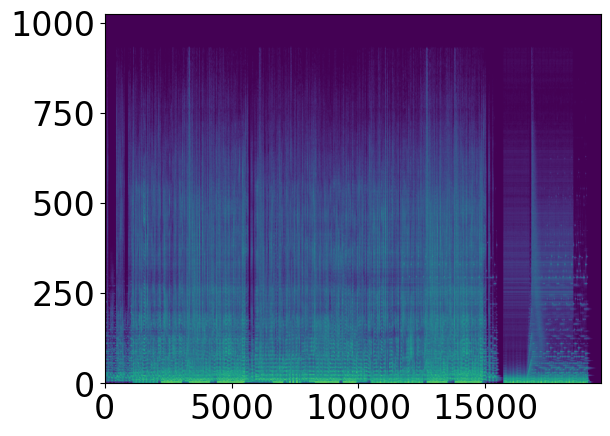

In [71]:
plt.imshow(D,aspect='auto',origin='lower');

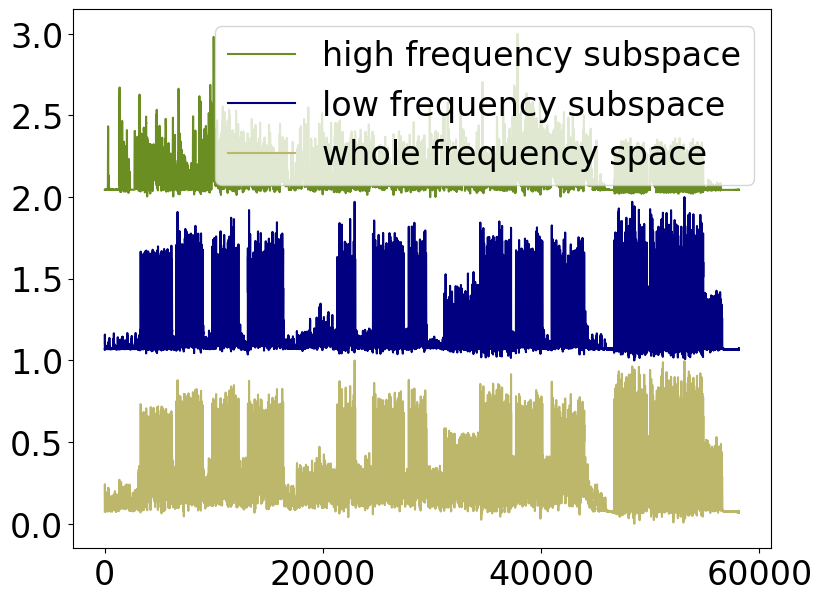

In [64]:
fig,ax = plt.subplots(1,1,figsize=(9,7))
ax.plot(sf3+2,label='high frequency subspace',color='olivedrab')
ax.plot(sf2+1,label='low frequency subspace',color='navy')
ax.plot(sf1,label='whole frequency space',color='darkkhaki')
plt.legend();

In [65]:
#Look at correlation between different spectral flux
s1s2 = np.corrcoef(sf1,sf2)[0][1]
s1s3 = np.corrcoef(sf1,sf3)[0][1]
s2s3 = np.corrcoef(sf2,sf3)[0][1]
# format into dataframe
moby = { 'low frequency subspace': [1,s1s2,s2s3],
       "whole frequency space": [s1s2,1,s1s3],
      "high frequency subspace": [s1s3,s2s3,1]}
df = pd.DataFrame.from_dict(moby) 

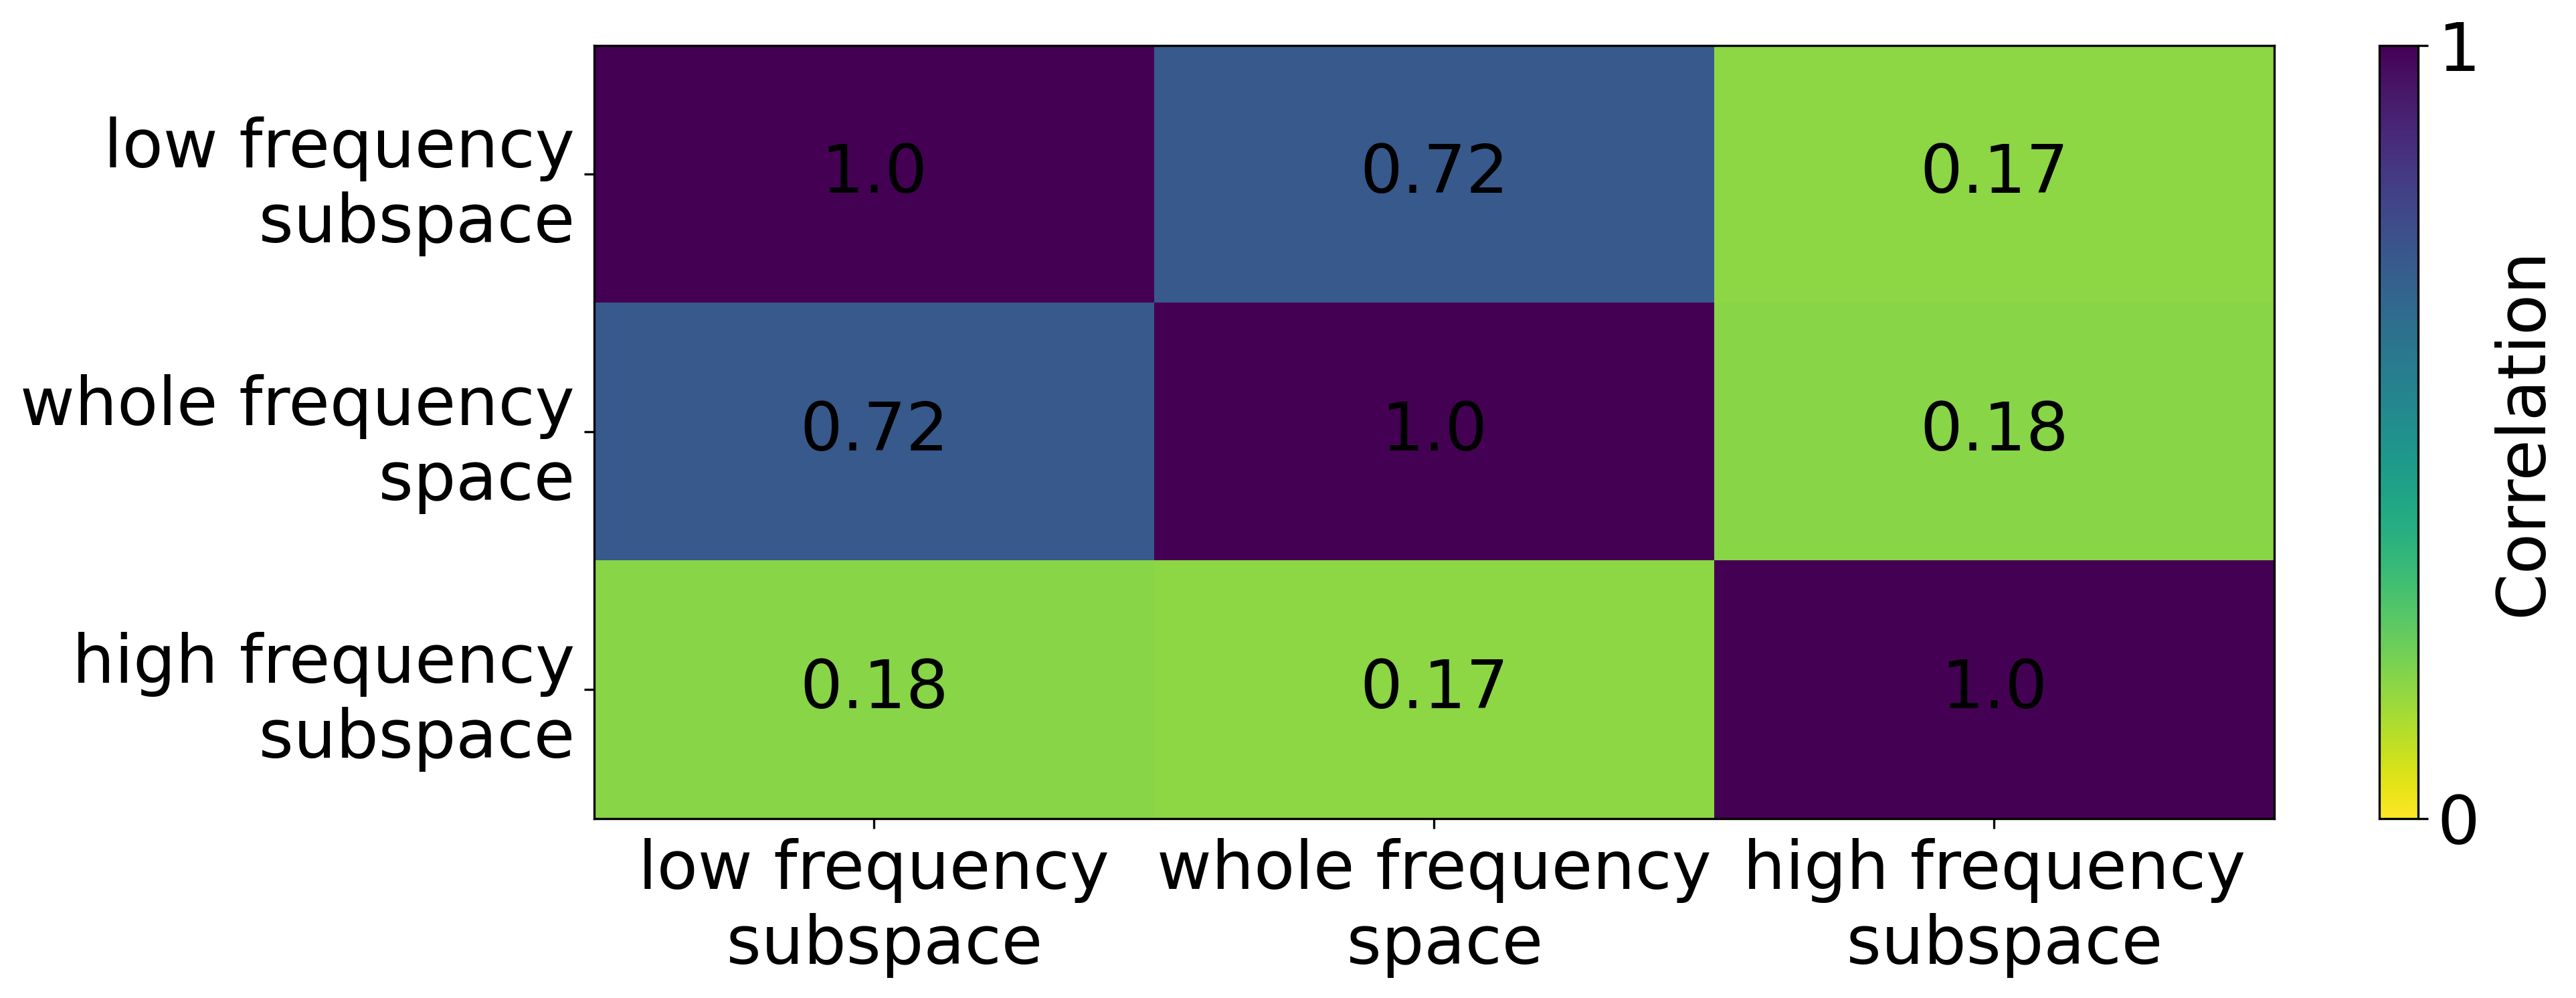

In [59]:
plt.rcParams.update({'font.size': 24})
figC,ax = plt.subplots(1,1,figsize=(13.5,5), facecolor='w', dpi=300)
variable_names = [
    'low frequency subspace', 
    "whole frequency space",
    "high frequency subspace"]


variable_names2 = [
    'low frequency\n subspace', 
    "whole frequency\n space",
    "high frequency\n subspace"]
corr12 = df.values
im = ax.imshow(corr12, vmin=0, vmax=1, aspect='auto',cmap='viridis_r')
# Loop over data dimensions and create text annotations.
for i in range(corr12.shape[0]):
    for j in range(corr12.shape[1]):
        text = ax.text(j, i, np.round(corr12[i, j],2),
                       ha="center", va="center", color="black")
ax.set_xticks(range(3))
ax.set_xticklabels(variable_names2)#, rotation=45)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_horizontalalignment('center')

ax.set_yticks(range(3))
ax.set_yticklabels(variable_names2)
cbar = plt.colorbar(im, ax=ax, ticks=[ 0, 1])
cbar.ax.set_ylabel('Correlation');


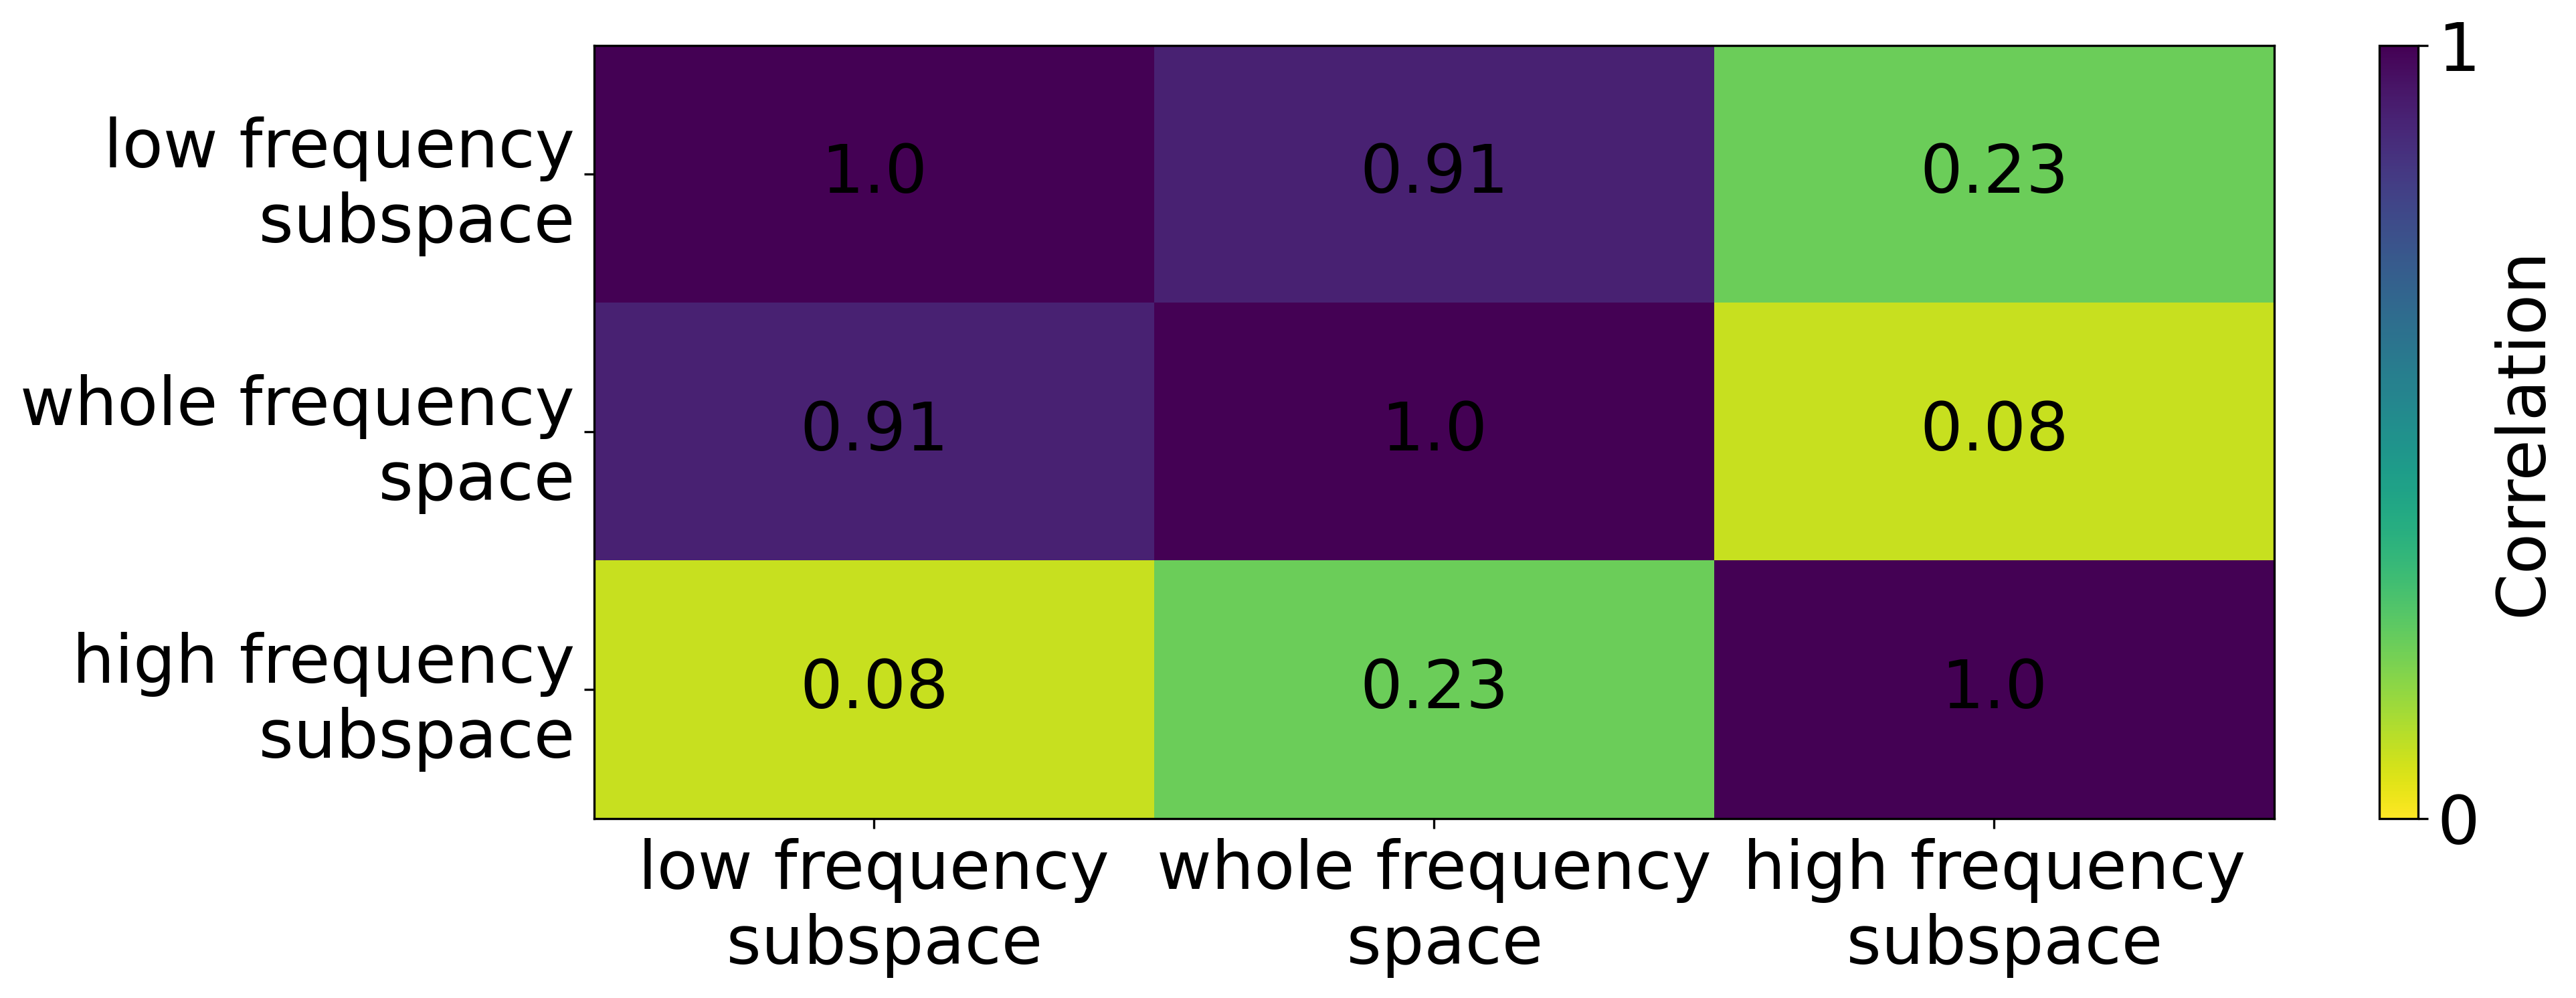

In [66]:
plt.rcParams.update({'font.size': 24})
figC,ax = plt.subplots(1,1,figsize=(13.5,5), facecolor='w', dpi=300)
variable_names = [
    'low frequency subspace', 
    "whole frequency space",
    "high frequency subspace"]


variable_names2 = [
    'low frequency\n subspace', 
    "whole frequency\n space",
    "high frequency\n subspace"]
corr12 = df.values
im = ax.imshow(corr12, vmin=0, vmax=1, aspect='auto',cmap='viridis_r')
# Loop over data dimensions and create text annotations.
for i in range(corr12.shape[0]):
    for j in range(corr12.shape[1]):
        text = ax.text(j, i, np.round(corr12[i, j],2),
                       ha="center", va="center", color="black")
ax.set_xticks(range(3))
ax.set_xticklabels(variable_names2)#, rotation=45)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_horizontalalignment('center')

ax.set_yticks(range(3))
ax.set_yticklabels(variable_names2)
cbar = plt.colorbar(im, ax=ax, ticks=[ 0, 1])
cbar.ax.set_ylabel('Correlation');
